In [ ]:
!pip install sktime --quiet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from pandas.core.common import random_state
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.model_selection import train_test_split, StratifiedKFold

In [4]:
def str2listf(l):
    l = l.replace("[", "")
    l = l.replace("]", "")
    l = l.replace("\n", "")
    l = l.split(', ')
    l = [float(i) for i in l]
    return l


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True User')
  plt.xlabel('Predicted User')

In [5]:
df = pd.read_csv('data_standard.csv')
# df.head()

In [6]:
# GLOBAL PRE-PROCESSING

df.index = df['Unnamed: 0'].tolist()
del df['Unnamed: 0']

df.ts_distance = df.ts_distance.apply(str2listf)
df.ts_pupil = df.ts_pupil.apply(str2listf)
df.x_coord = df.x_coord.apply(str2listf)
df.y_coord = df.y_coord.apply(str2listf)
df['series_original_lenght'] = df['series_original_lenght'].apply(lambda i: int(i))
df['speed'] = df['speed'].apply(lambda i: float(i))


tuning model...
(data is shuffled)

_____________________________________________________________________

fold:  1
accuracy:  0.8869565217391304

fold:  2
accuracy:  0.8869565217391304

fold:  3
accuracy:  0.9304347826086956

fold:  4
accuracy:  0.9043478260869565

fold:  5
accuracy:  0.9210526315789473

best acc:  0.93

_____________________________________________________________________

fold:  1
accuracy:  0.9130434782608695

fold:  2
accuracy:  0.9391304347826087

fold:  3
accuracy:  0.8695652173913043

fold:  4
accuracy:  0.8782608695652174

fold:  5
accuracy:  0.8245614035087719

best acc:  0.94

_____________________________________________________________________

fold:  1
accuracy:  0.9130434782608695

fold:  2
accuracy:  0.8869565217391304

fold:  3
accuracy:  0.8956521739130435

fold:  4
accuracy:  0.8782608695652174

fold:  5
accuracy:  0.9298245614035088

best acc:  0.93

_____________________________________________________________________

fold:  1
accuracy:  0.904347

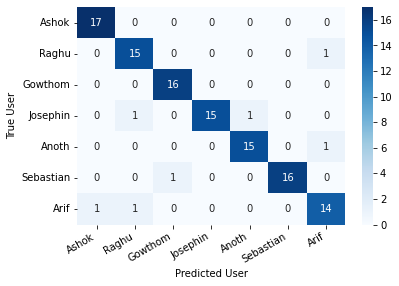

In [9]:
from warnings import simplefilter


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df.participant_name.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df.groupby('participant_name', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  df_sample.participant_name.value_counts()

  y = df_sample['participant_name']
  X = df_sample
  del X['participant_name']

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    del X_train['pattern_name']
    del X_train['speed']
    del X_train['series_original_lenght']

    del X_test['pattern_name']
    del X_test['speed']
    del X_test['series_original_lenght']

    X_train = X_train.applymap(lambda s: pd.Series(s))
    X_test = X_test.applymap(lambda s: pd.Series(s))

    # print("training classifier...")
    minirocket_multi = MiniRocketMultivariate()
    minirocket_multi.fit(X_train)
    X_train_transform = minirocket_multi.transform(X_train)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(X_train_transform, y_train)

    X_test_transform = minirocket_multi.transform(X_test)

    print("accuracy: ", classifier.score(X_test_transform, y_test))

    predictions = classifier.predict(X_test_transform)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test_transform, y_test):
      best_acc = classifier.score(X_test_transform, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

show_confusion_matrix(df_cm)
plt.show()

In [ ]:
# no norm and default alphas

from warnings import simplefilter


simplefilter(action='ignore', category=FutureWarning)


seeds = [42, 1, 999, 4276, 67534]
n_samples = min(df.participant_name.value_counts())

print("number of samples per class: ", n_samples)
print("\ntuning model...")
print("(data is shuffled)")

best_global_acc = 0
best_model = pd.DataFrame()

for seed in seeds:

  df_sample = df.groupby('participant_name', group_keys=False).apply(lambda x: x.sample(n_samples, random_state=seed))
  df_sample.participant_name.value_counts()

  y = df_sample['participant_name']
  X = df_sample
  del X['participant_name']

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

  print("\n_____________________________________________________________________")

  best_acc = 0
  best_df_eval = pd.DataFrame()

  for ix, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    print("\nfold: ", ix)
    X_train, X_test = X.take(train_index), X.take(test_index)
    y_train, y_test = y.take(train_index), y.take(test_index)

    del X_train['pattern_name']
    del X_train['speed']
    del X_train['series_original_lenght']

    del X_test['pattern_name']
    del X_test['speed']
    del X_test['series_original_lenght']

    X_train = X_train.applymap(lambda s: pd.Series(s))
    X_test = X_test.applymap(lambda s: pd.Series(s))

    # print("training classifier...")
    minirocket_multi = MiniRocketMultivariate()
    minirocket_multi.fit(X_train)
    X_train_transform = minirocket_multi.transform(X_train)

    classifier = RidgeClassifierCV(normalize=False)
    classifier.fit(X_train_transform, y_train)

    X_test_transform = minirocket_multi.transform(X_test)

    print("accuracy: ", classifier.score(X_test_transform, y_test))

    predictions = classifier.predict(X_test_transform)

    df_eval = pd.DataFrame([(p, t) for p, t in zip(predictions, y_test.tolist())], columns=["prediction", "truth"])

    if best_acc < classifier.score(X_test_transform, y_test):
      best_acc = classifier.score(X_test_transform, y_test)
      best_df_eval = df_eval

  print("\nbest acc: ", round(best_acc, 2))
  if best_acc > best_global_acc:
    best_global_acc = best_acc
    best_model = best_df_eval

print("\nbest global acc: ", round(best_global_acc, 2))
print(classification_report(best_model.truth.tolist(), best_model.prediction.tolist(), target_names=list(set(best_model.truth.tolist()))))

cm = confusion_matrix(best_model.truth.tolist(), best_model.prediction.tolist())
df_cm = pd.DataFrame(cm, index=list(set(best_model.truth.tolist())), columns=list(set(best_model.truth.tolist())))

show_confusion_matrix(df_cm)
plt.show()

number of samples per class:  82

tuning model...
(data is shuffled)

_____________________________________________________________________

fold:  1
accuracy:  0.8260869565217391

fold:  2
accuracy:  0.8347826086956521

fold:  3
accuracy:  0.8521739130434782

fold:  4
accuracy:  0.8608695652173913

fold:  5
accuracy:  0.8771929824561403

best acc:  0.88

_____________________________________________________________________

fold:  1
